# Danish fire insurance data

In [1]:
import sys
sys.path.insert(0,'/home/pgoffard/BayesSplicedModels/')
%run ../../preamble.py
danish = pd.read_csv("../../Data/Danish/danish.csv").x
tea_thresholds = pd.read_csv("../../Data/Danish/tea_threshold.csv")
import random
random.seed(123)

In [2]:
# The data
X = danish.values
# Model for the bulk distribution
body_model_names = ["Inverse-Gaussian"]
# body_model_names = ["Exp", "Gamma"]
body_model_param_names = [["μ1", "λ1"]]
# Prior distributions over the parameters of the bulk distribution
body_model_priors= [
    [bsm.prior_model('gamma',body_model_param_names[0][0], 1, 1),
    bsm.prior_model('gamma',body_model_param_names[0][1], 1, 1)]
]


# Spliced model with free threshold

In [3]:
γ_prior = bsm.prior_model('uniform', "γ", min(X), max(X))

In [4]:
# Model for the tail of the distribution
tail_model_names = ["Exp", "Gamma", "Weibull", "Inverse-Gaussian", "Lognormal", "Log-Logistic", "Lomax", "Burr", "Pareto-Tail", "GPD-Tail", "Inverse-Gamma", "Inverse-Weibull"]
# tail_model_names = ["Exp", "Gamma", "Weibull"]

tail_model_param_names = [['λ2'], ["r2", "m2"], ["k2", "β2"], ["μ2", "λ2"], ["μ2", "σ2"], ["β2", "σ2"], ["α2", "σ2"], ["α2", "β2", "σ2"], ["α2"], ["ξ2","σ2"], ["r2", "m2"], ["k2", "β2"]]

# Prior distributions over the parameters of the bulk distribution
tail_model_priors= [[bsm.prior_model('gamma',tail_model_param_names[0][0], 1, 1)],
                [bsm.prior_model('gamma',tail_model_param_names[1][0], 1, 1), bsm.prior_model('gamma',tail_model_param_names[1][1], 1, 1)], 
                [bsm.prior_model('gamma',tail_model_param_names[2][0], 1, 1), bsm.prior_model('gamma',tail_model_param_names[2][1], 1, 1)],
                [bsm.prior_model('gamma',tail_model_param_names[3][0], 1, 1), bsm.prior_model('gamma',tail_model_param_names[3][1], 1, 1)],
                [bsm.prior_model('normal',tail_model_param_names[4][0], 0, 0.5), bsm.prior_model('gamma',tail_model_param_names[4][1], 1, 1)],
                [bsm.prior_model('gamma',tail_model_param_names[5][0], 1, 1), bsm.prior_model('gamma',tail_model_param_names[5][1], 1, 1)],
                [bsm.prior_model('gamma',tail_model_param_names[6][0], 1, 1), bsm.prior_model('gamma',tail_model_param_names[6][1], 1, 1)],
                [bsm.prior_model('gamma',tail_model_param_names[7][0], 1, 1), bsm.prior_model('gamma',tail_model_param_names[7][1], 1, 1), bsm.prior_model('gamma',tail_model_param_names[7][2], 1, 1)],
                [bsm.prior_model('gamma',tail_model_param_names[8][0], 1, 1)],
                [bsm.prior_model('gamma',tail_model_param_names[9][0], 1, 1), bsm.prior_model('gamma',tail_model_param_names[9][1], 1, 1)],
                [bsm.prior_model('gamma',tail_model_param_names[10][0], 1, 1), bsm.prior_model('gamma',tail_model_param_names[10][1], 1, 1)],
                [bsm.prior_model('gamma',tail_model_param_names[11][0], 1, 1), bsm.prior_model('gamma',tail_model_param_names[11][1], 1, 1)]
]
p_prior = bsm.prior_model('uniform',"p", 0, 1)

#Splicing model type
splicing_types = ["continuous", "simple", "disjoint"]

# Setting the models
fs, f_names, prior_spliced_model = [], [], []
for i in range(len(body_model_names)):
    for j in range(len(tail_model_names)):
        for splicing_type in splicing_types:
            f1, f2 =  bsm.loss_model(body_model_names[i], body_model_param_names[i]), bsm.loss_model(tail_model_names[j], tail_model_param_names[j])
            fs.append(bsm.spliced_loss_model(f1 , f2, splicing_type))
            f_names.append(body_model_names[i] +"_"+ tail_model_names[j]+"_"+splicing_type)
            if splicing_type == "disjoint": 
                prior_spliced_model.append(bsm.independent_priors(body_model_priors[i] + tail_model_priors[j] + [γ_prior, p_prior]))
            else:
                prior_spliced_model.append(bsm.independent_priors(body_model_priors[i] + tail_model_priors[j] + [γ_prior]))  
for f in fs:
    f.set_ppf()
f_spliced_dic = dict(zip(f_names, fs))
splits = 1
len(f_names)/splits

36.0

In [5]:
popSize, ρ, c, n_step_max, err, paralell, n_proc, verbose = 10000, 1/2, 0.99, 25, 1e-6, False, 4, False
def fit_spliced_models(i):
    print(f_names[i])
    trace, log_marg, DIC, WAIC = bsm.smc_likelihood_annealing(X, fs[i], popSize, prior_spliced_model[i], ρ, c,n_step_max, err, paralell, 4, verbose)
    return([trace, log_marg, DIC, WAIC])

res = []
for k in range(splits):
    print("Model batch #"+str(k))
    %time res_sub = Parallel(n_jobs=int(len(fs)/splits))(delayed(fit_spliced_models)(i) for i in range(int(k * len(f_names) / splits), int((k+1) * len(f_names)/splits)))
    res += res_sub


Model batch #0
CPU times: user 11.4 s, sys: 337 ms, total: 11.7 s
Wall time: 12min 24s


In [6]:
fit_spliced_models_dic = dict(zip(f_names, res))
γ_map = np.array([fit_spliced_models_dic[f_names[k]][0]['γ'].mean() for k in range(len(fit_spliced_models_dic))])
spliced_model_df = pd.DataFrame({'model':f_names,
                                 "d": np.array([f.d for f in fs]),
                                 "γ_map": np.array([fit_spliced_models_dic[f_names[k]][0]['γ'].mean() for k in range(len(fit_spliced_models_dic))]),
                                 'log_marg':  np.array([fit_spliced_models_dic[f_names[k]][1] for k in range(len(fit_spliced_models_dic))]), 
                                 "DIC": np.array([fit_spliced_models_dic[f_names[k]][2] for k in range(len(fit_spliced_models_dic))]), 
                                 "WAIC":np.array([fit_spliced_models_dic[f_names[k]][3] for k in range(len(fit_spliced_models_dic))])})
spliced_model_df["posterior_probability"] = np.exp(spliced_model_df["log_marg"] - np.max(spliced_model_df["log_marg"])) / np.sum(np.exp(spliced_model_df["log_marg"] - np.max(spliced_model_df["log_marg"]))) 

spliced_model_df["Wass_dist"] = np.array([bsm.compute_Wasserstein(X, f_spliced_dic[model_name], fit_spliced_models_dic[model_name][0].mean().values, 1) for model_name in spliced_model_df["model"].values])
spliced_model_df.sort_values(by='log_marg', ascending=False)

,model,d,γ_map,log_marg,DIC,WAIC,posterior_probability,Wass_dist
23,Inverse-Gaussian_Burr_disjoint,7,0.824367,-3807.314613,7537.388909,7555.339090,9.995984e-01,448.774268
35,Inverse-Gaussian_Inverse-Weibull_disjoint,6,0.824491,-3815.134492,7556.340585,7574.312702,4.015088e-04,721.987193
34,Inverse-Gaussian_Inverse-Weibull_simple,5,0.824465,-3823.978848,7575.543828,7592.553829,5.789486e-08,717.375981
17,Inverse-Gaussian_Log-Logistic_disjoint,6,0.824564,-3824.779428,7571.861330,7589.734480,2.599877e-08,744.948720
32,Inverse-Gaussian_Inverse-Gamma_disjoint,6,0.824559,-3825.698159,7574.138229,7592.264814,1.037416e-08,805.434440
22,Inverse-Gaussian_Burr_simple,6,0.824394,-3827.165506,7560.415332,7575.694381,2.391620e-09,538.419804
20,Inverse-Gaussian_Lomax_disjoint,6,0.824619,-3832.000193,7593.827321,7611.298597,1.901141e-11,796.946024
29,Inverse-Gaussian_GPD-Tail_disjoint,6,0.824620,-3832.513017,7593.596278,7611.544198,1.138407e-11,796.943446
16,Inverse-Gaussian_Log-Logistic_simple,5,0.824569,-3832.803901,7590.825535,7607.931696,8.510760e-12,749.592793
31,Inverse-Gaussian_Inverse-Gamma_simple,5,0.824542,-3834.815942,7593.519196,7610.290431,1.138021e-12,805.726854


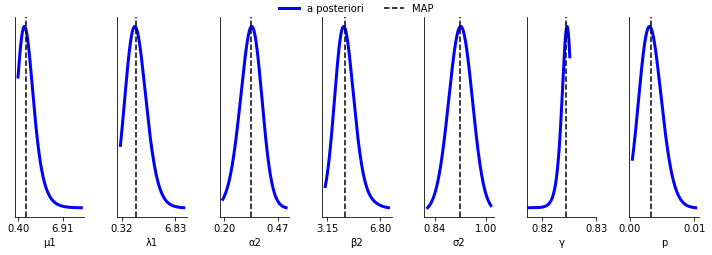

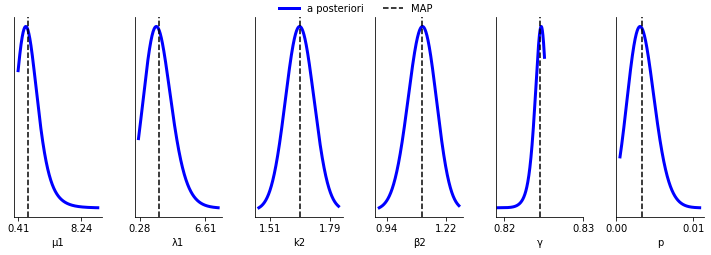

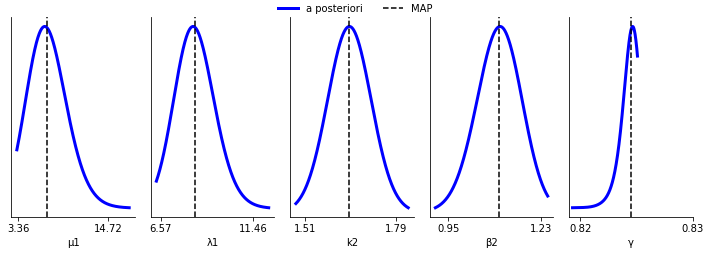

In [7]:
model_names = spliced_model_df.sort_values(by='log_marg', ascending=False)["model"][:3]
for model_name in model_names:
    f, trace = f_spliced_dic[model_name], fit_spliced_models_dic[model_name][0]
    # print(trace.mean().values)
    bsm.posterior_plots(f, trace)
    # bsm.trace_plots(f, trace)
#     bsm.qq_plot(X, f, trace.mean().values)


In [8]:
import pickle
spliced_model_df.to_csv("../../Data/Danish/danish_splicing_model_fit_"+body_model_names[0]+".csv", sep=',')
with open('../../Data/Danish/trace_danish_'+body_model_names[0]+'.obj', 'wb') as fp:
    pickle.dump(fit_spliced_models_dic, fp)